In [1]:
import os
import tensorflow as tf
import shutil

In [2]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# mendowload dataset menggunakan API command dari kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 339M/346M [00:02<00:00, 212MB/s]
100% 346M/346M [00:02<00:00, 148MB/s]


In [4]:
# mengekstrak file zip
import zipfile
zip_file = zipfile.ZipFile('/content/intel-image-classification.zip')
zip_file.extractall('/content/')

In [6]:
path = '/content/seg_train'

In [7]:
from sklearn.utils import validation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    subset = 'training',
    class_mode = 'categorical'
)
validation_generator = test_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    subset = 'validation',
    class_mode = 'categorical'
)

Found 11228 images belonging to 1 classes.
Found 2806 images belonging to 1 classes.


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>1.1):
      print("\n Proses pencarian terhenti. Akurasi sudah mencapai 90%!")
      self.model.stop_training = True

callback = mycallback()

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [16]:
num_epoch = 10
history = model.fit(train_generator,
                    steps_per_epoch = 6,
                    epochs = num_epoch,
                    validation_data = validation_generator,
                    verbose = 1,
                    callbacks=callback)

Epoch 1/10
6/6 [==============================] - 29s 6s/step - loss: 0.0000e+00 - accuracy: 0.9323 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 30s 6s/step - loss: 0.0000e+00 - accuracy: 0.8698 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 31s 6s/step - loss: 0.0000e+00 - accuracy: 0.8830 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 29s 6s/step - loss: 0.0000e+00 - accuracy: 0.9167 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 29s 6s/step - loss: 0.0000e+00 - accuracy: 0.8958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 30s 6s/step - loss: 0.0000e+00 - accuracy: 0.9167 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 30s 6s/step - loss: 0.0000e+00 - accuracy: 0.8906 - val_loss: 0.0000e+00 -

<function matplotlib.pyplot.show(*args, **kw)>

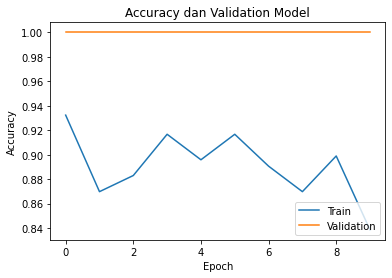

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy dan Validation Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

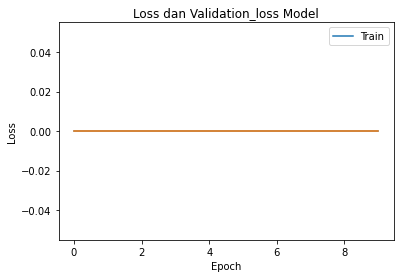

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss dan Validation_loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show

In [ ]:
convert = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model =convert.convert()

In [ ]:
with tf.io.gfile.GFile('model.tflite','wb') as f:
  f.write(tflite_model)